In [1]:
from cmp import *
% matplotlib notebook

[1. 0. 0.]
[0.5 0.5 0. ]
[0. 0. 1.]
Lattice and basis before rotation
[ 0.80473785  0.50587936 -0.31061722]
[0.24706032 0.65530861 0.09763107]
[ 0.50587936 -0.31061722  0.80473785]
[0. 0. 0.]
Lattice and basis after rotation:
[ 0.70710678 -0.70073484  0.09471373]
[0.70710678 0.         0.        ]
[0.         0.13394544 0.99098871]
[0. 0. 0.]
Unpruned Atomic Positions
[[-2.82842712  1.13357879 -2.17140487]
 [-2.82842712  1.26752423 -1.18041616]
 [-2.82842712  1.40146967 -0.18942746]
 ...
 [ 5.65685425 -2.53504846  2.36083233]
 [ 5.65685425 -2.40110302  3.35182104]
 [ 5.65685425 -2.26715759  4.34280975]]
Lattice: base centred cubic
Pruned Atomic Positions
[[0.         0.83468027 0.89627498]
 [0.         0.96862571 1.88726369]
 [0.70710678 0.83468027 0.89627498]
 [0.70710678 0.96862571 1.88726369]
 [1.41421356 0.83468027 0.89627498]
 [1.41421356 0.96862571 1.88726369]
 [0.         0.         0.        ]
 [0.         0.13394544 0.99098871]
 [0.         0.26789088 1.98197742]
 [0.70710678 

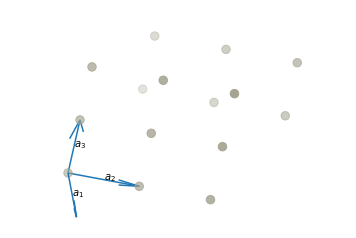

In [2]:
# Inputs
eq = np.isclose
# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

LatticeType = "base centred cubic"

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)
verbose = True


# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# Hard: Sets a hard limit on the plotting boundary (default  x = y = z = [0,2])
# Dynamic: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# WDynamic: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

(a1, a2, a3), basis = LatticeChooser(lattice_name=LatticeType)
print(a1)
print(a2)
print(a3)
R = RotMatrix()
a1, a2, a3, basis = rotate(a1,a2,a3,basis,R)


#LatticeCreator(a1,a2,a3,basis,colors,sizes,LimType,GridType,Mins,Maxs)
LatticeCreator(a1,a2,a3,basis,Maxs=Maxs,verb=verbose,GridType="none")

In [31]:
def rotate(a1, a2, a3, basis, R):
    """
    Rotates the lattice
    """
    return R@a1, R@a2, R@a3, (R@basis.T).T

def parallel(a1,a2):
    """
    returns True if vectors are (anti)parallel and false if they're not
    """
    mag1 = mag(a1)
    mag2 = mag(a2)
    cos12 = a1.dot(a2) / (mag1 * mag2)
    para = eq(1,cos12) or eq(-1,cos12)
    return para
    

def rotator(a1, a2, a3, basis, latticetype=None, verb=False):
    """
    Rotates the lattice to make plotting gridlines easier
    """
    # We remember, that |a x b| = |a| |b| sin(theta)
    eq = np.isclose
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])
    # Check for orthogonality
    ortho12 = eq(0, np.dot(a1, a2))
    ortho31 = eq(0, np.dot(a1, a3))
    ortho23 = eq(0, np.dot(a2, a3))
    
    face_centred = "face centred" in latticetype or latticetype == "fcc"
    
    if verb:
        print("Before:")
        print(a1)
        print(a2)
        print(a3)
        print(basis)

    if "hexagonal" in latticetype:
        a1, a2, a3, basis = rotateHex(a1, a2, a3, basis)
    elif "base centred monoclinic" in latticetype:
        a1, a2, a3, basis = rotatebcm(a1, a2, a3, basis)
    elif face_centred:
        a1, a2, a3, basis = rotatefacecentred(a1, a2, a3, basis, verb)
    elif ortho12:
        # We choose a1 to align along x
        a1cross = np.cross(a1, x)
        theta = np.arcsin(mag(a1cross) / mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)

        # Now we align a2 along y
        # But we gotta make sure we rotate in the right direction
        a2cross = np.cross(a2, y)
        sign = np.sign(a2cross)[0]
        theta = sign * np.arcsin(mag(a2cross) / mag(a2))
        r2 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
        
        # Let's check that a2 is along y:
        if parallel(a2,y):
            pass
        else:
            # We rotated the wrong way! Let's rotate the other way twice
            r2 = RotMatrix(x, -2*theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
            
    elif ortho31:
        # We choose a1 to align along x
        a1cross = np.cross(a1, x)
        theta = np.arcsin(mag(a1cross) / mag(a1))
        r1 = RotMatrix(a1cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
        
        # Now we align a3 along y
        a3cross = np.cross(a3, y)
        sign = np.sign(a3cross)[0]
        theta = np.arcsin(mag(a3cross) / mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
        
        # Let's check that a3 is along y:
        if parallel(a3,y):
            pass
        else:
            # We rotated the wrong way! Let's rotate the other way twice
            r3 = RotMatrix(x, -2*theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
        
    elif ortho23:
        # We choose a2 to align along x
        a2cross = np.cross(a2, x)
        theta = np.arcsin(mag(a2cross) / mag(a2))
        r2 = RotMatrix(a2cross, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)

        # Now we align a3 along y
        a3cross = np.cross(a3, y)
        sign = np.sign(a3cross)[0]
        theta = sign * np.arcsin(mag(a3cross) / mag(a3))
        r3 = RotMatrix(x, theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
        
        # Let's check that a3 is along y:
        if parallel(a3,y):
            pass
        else:
            # We rotated the wrong way! Let's rotate the other way twice
            r3 = RotMatrix(x, -2*theta)
            a1, a2, a3, basis = rotate(a1, a2, a3, basis, r3)
    else:
        # Well, it doesn't really matter here, if none of them are orthogonal
        # to each other. We'll just use latticevector gridlines and leave this
        # be.
        pass

    # Let's sanitize the coordinates that are close to 0 (say if a1x =
    # 2*10^-10, then we set it equal 0)
    a1[eq(a1, 0)] = 0
    a2[eq(a2, 0)] = 0
    a3[eq(a3, 0)] = 0
    basis[eq(basis, 0)] = 0
    
    if verb:
        print("after")
        print(a1)
        print(a2)
        print(a3)
        print(basis)

    return a1, a2, a3, basis


In [32]:
def rotatebcm(a1, a2, a3, basis):
    """
    rotation function for base centred monoclinic. Rotates the lattice such that a1 is along x, and a2 is in the xy-plane
    """
    x = np.array([1,0,0])
    y = np.array([0,1,0])
    
    # We align a1 along x
    a1cross = np.cross(a1, x)
    theta = np.arcsin(mag(a1cross) / mag(a1))
    r1 = RotMatrix(a1cross, theta)
    a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
    
    # Get the rotation matrix to align a2 in the xy plane (vector rejection parallel to y)
    theta, r2 = RotMatrixAlong(a1,a2,y)
    a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
    
    # Make sure a2 is perpendicular to z
    if eq(a2[2],0):
        pass
    else:
        # rotate the other way!
        r2 = RotMatrix(a1,-2*theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
    
    return a1, a2, a3, basis
    

In [33]:
def rotatefacecentred(a1, a2, a3, basis, verb=False):
    """
    Rotation function for face centred lattices
    """
    ma1 = a1.dot(a1)
    ma2 = a2.dot(a2)
    ma3 = a3.dot(a3)
    
    # First we get the relevant lengths:
    a = np.sqrt(2 * (ma1 + ma2 - ma3))
    b = np.sqrt(2 * (ma1 - ma2 + ma3))
    c = np.sqrt(2 * (-ma1 + ma2 + ma3))
    
    
    # And now the "proper" lattice vectors
    a1prop = np.array([a/2, b/2, 0])
    a2prop = np.array([a/2, 0, c/2])
    a3prop = np.array([0, b/2, c/2])

    # Now we align a1 with a1prop:
    a1cross = np.cross(a1, a1prop)
    theta = np.arcsin(mag(a1cross) / (mag(a1) * mag(a1prop)))
    r1 = RotMatrix(a1cross, theta)
    a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
    
    # And of course check that we've rotated correctly
    if eq(a1, a1prop).all():
        pass
    else:
        r1 = RotMatrix(a1cross, -2*theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r1)
    
    # Next we align a2 with a2prop:
    theta, r2 = RotMatrixAlong(a1prop, a2, a2prop)
    a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)
    if eq(a2, a2prop).all():
        # We rotated properly!
        pass
    else:
        # Rotate the other way
        r2 = RotMatrix(a1prop, -2*theta)
        a1, a2, a3, basis = rotate(a1, a2, a3, basis, r2)

    # To be sure, let's see if a3 and a3prop are (anti)parallel:
    cos3 = a3.dot(a3prop)/(mag(a3)*mag(a3prop))
    if verb:
        if eq(cos3, 1):
            print("a3 and a3prop are parallel")
        elif eq(cos3, -1):
            print("a3 and a3prop are ANTIparallel")
        else:
            print("a3 and a3prop are neither parallel or antiparallel. Check!")
    
    return a1, a2, a3, basis

In [34]:
#lattices = ["tetragonal face centred", "orthorhombic face centred",
#            "base centred monoclinic 1", "base centred monoclinic 2",
#            "base centred monoclinic 3"]

lattices = ["base centred monoclinic 1", "base centred monoclinic 2", "base centred monoclinic 3"]
lattices = ["tetragonal face centred"]
lattices = ["fcc"]
for name in lattices:
    # Create the lattice
    (a1,a2,a3), basis = LatticeChooser(name)
    a1,a2,a3,basis = rotate(a1,a2,a3,basis,RotMatrix())
    # rotate the lattice and basis
    print(name)
    a1,a2,a3,basis = rotator(a1, a2, a3, basis, latticetype=name, verb=True)

fcc
Before:
[0.24706032 0.65530861 0.09763107]
[0.65530861 0.09763107 0.24706032]
[0.09763107 0.24706032 0.65530861]
[0. 0. 0.]
a3 and a3prop are parallel
after
[0.5 0.5 0. ]
[0.5 0.  0.5]
[0.  0.5 0.5]
[0. 0. 0.]


False
